In [45]:
import hddCRP.simulations
import hddCRP.modelFittingSequential
import hddCRP.behaviorDataHandlers
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
import pandas as pd
import seaborn as sns
from itertools import product

In [46]:
results_directory = "Results/Simulations"
if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)
    
simulation_id = 0; # for naming file

overwrite_existing_results = True

run_range = range(6,7)

num_warmup_samples =5000
num_samples = 5000

initialize_fit_with_real_connections = False;

prior_scales = None
prior_shapes = None

if(simulation_id == 0):
    depth  = 3; # look 2 actions in the past
    alphas = [15,15,15] # concentration parameters: per depth in the hddCRP tree. alphas[0] first level (no action context), alphas[1] is the second (for regularizing p(y_t | y_{t-1})), etc...
    between_session_time_constants = np.array([[ 1]]) # units = sessions
    within_session_time_constant = [40] # units = actions
    session_length = lambda run_idx, block_idx : 50*block_idx # trials per session
    num_sessions   = lambda run_idx, block_idx : 1 # trials per session

    action_labels = [0,1,2] 
    maze_symbols = ['A']
    uniform_prior = False
    min_blocks_per_type = 1
    max_blocks_per_type = 2;
    prior_scales = {"alpha" : 5, "tau_within" : 25, "tau_between" : 10}
    prior_shapes = {"alpha" : 2, "tau_within" :  2, "tau_between" : 2}


block_range = range(min_blocks_per_type, max_blocks_per_type+1)

true_parameters = {}
alpha_strs = ["no", "one_back", "two_back", "three_back"]
for dd in range(depth):
    true_parameters["alpha_concentration_" + alpha_strs[dd] + "_context"] = alphas[dd]
for aa_i, aa in enumerate(maze_symbols): 
    true_parameters["within_session_" + aa + "_time_constant"] = within_session_time_constant[aa_i]

if(np.max([num_sessions(rr,bb) for rr,bb in product(run_range, block_range)]) > 1):
    for aa_i, aa in enumerate(maze_symbols):
        true_parameters[aa + "_to_" + aa + "_session_time_constant"] = between_session_time_constants[aa_i,aa_i]


for aa_i, aa in enumerate(maze_symbols):
    for bb_i, bb in enumerate(maze_symbols[(aa_i+1):]):
        true_parameters[aa + "_to_" + bb + "_session_time_constant"] = between_session_time_constants[aa_i,bb_i]

            
rng_seed_sim = 100 + 10001;
rng_seed_fit = 200 + 10002;
rng_sim = np.random.Generator(np.random.MT19937(rng_seed_sim))
rng_fit = np.random.Generator(np.random.MT19937(rng_seed_fit))

In [47]:
for run_idx in run_range:
    print("\rRun " + str(run_idx))
    for block_idx in block_range:
        print("\tBlock " + str(block_idx))
        filename = "{results_directory}/Sim_{sim_num}_size_{N_blocks_per_type}_run_{run_idx}.pkl".format(results_directory=results_directory, sim_num=simulation_id, N_blocks_per_type=block_idx, run_idx=run_idx)
        if(not os.path.isfile(filename) or overwrite_existing_results):
            rng_seed_sim = 100 + 10000*run_idx;
            rng_seed_fit = 200 + 10000*run_idx;
            rng_sim = np.random.Generator(np.random.MT19937(rng_seed_sim))
            rng_fit = np.random.Generator(np.random.MT19937(rng_seed_fit))


            session_lengths = [session_length(run_idx, block_idx)] * (len(maze_symbols) * num_sessions(run_idx, block_idx))
            session_labels = [];
            for aa in maze_symbols:
                session_labels += [aa] * num_sessions(run_idx, block_idx)  # which maze

            seqs, connection_data = hddCRP.simulations.simulate_sequential_hddCRP(session_lengths, session_labels, action_labels, depth, rng_sim, alphas, 
                    between_session_time_constants = between_session_time_constants, within_session_time_constant = within_session_time_constant)

            simulation_info = {"rng_seed_simulation" : rng_seed_sim, "rng_seed_fitting" : rng_seed_fit, "rng_type" : "MT19937",
                            "session_lengths" : session_lengths, "session_labels" : session_labels, "action_labels" : action_labels,
                            "seqs" : seqs, "connection_data" : connection_data}

            model = hddCRP.simulations.create_hddCRPModel_from_simulated_sequential_hddCRP(seqs, connection_data, rng=rng_fit, use_real_parameters=initialize_fit_with_real_connections)
            
            tau_names = [str(xx) for xx in model.weight_param_labels]
            alphas_names = ["alpha_concentration_no_context", "alpha_concentration_one_back_context", "alpha_concentration_two_back_context"]
            model, samples, step_size_settings = hddCRP.behaviorDataHandlers.sample_model_for_maze_data(model, num_samples=num_samples, 
                            num_warmup_samples=num_warmup_samples, print_every=2500, uniform_prior=uniform_prior, prior_shapes=prior_shapes, prior_scales=prior_scales)

            MCMC_info = {"initialized_with_true_connections" : initialize_fit_with_real_connections,
                        "step_size_settings" : step_size_settings.to_dict(),
                        "num_warmup_samples" : num_warmup_samples,
                        "num_samples" : num_samples,
                        "uniform_prior" : uniform_prior}
            samples["tau_parameter_names"] = tau_names
            samples["alphas_names"] = alphas_names[:depth]
            
            # save results to filename
            with open(filename, "wb") as results_file:
                results_data = {"true_parameters" : true_parameters,
                                "simulation_info" : simulation_info,
                                "MCMC_info" : MCMC_info,
                                "samples" : samples}
                pickle.dump(results_data, results_file)


Run 6
	Block 1
Sample 0 / 10000
Sample 2500 / 10000
Sample 5000 / 10000
Sample 7500 / 10000
	Block 2
Sample 0 / 10000
Sample 2500 / 10000
Sample 5000 / 10000
Sample 7500 / 10000


In [48]:
empty_data = np.zeros((num_samples, len(run_range)*len(true_parameters)*len(block_range)))
empty_data.fill(np.nan)
parameters = pd.DataFrame(empty_data,
                  columns=pd.MultiIndex.from_product([true_parameters.keys(), block_range, run_range], names=["parameter", "sessions per maze", "run"]))
parameters.index.name='sample'

# plot results: MCMC credible intervals for each parameter as a function of N_blocks_per_type
print("Metropolis-Hastings acceptance rate and step size:")
for run_idx in run_range:
    for block_idx in block_range:
        filename = "{results_directory}/Sim_{sim_num}_size_{N_blocks_per_type}_run_{run_num}.pkl".format(results_directory=results_directory, sim_num=simulation_id, N_blocks_per_type=block_idx, run_num=run_idx)
        if(not os.path.isfile(filename)):
            raise RuntimeError("Results file not found: " + filename)
            # throw error
        
        # load file
        with open(filename, "rb") as results_file:
            results = pickle.load(results_file)

            # '''
            # Make sure all the files loaded are correct
            # '''

            # # check for correct results fields
            # expected_fields = ["true_parameters", "simulation_info", "MCMC_info", "samples"]
            # if(not isinstance(results, dict) or not np.all(np.isin(expected_fields, list(results.keys())))):
            #     raise ValueError("File " + filename + " does not contain expected results fields")
            
            # session_lengths = [session_length(run_idx)] * (len(maze_symbols) * N_blocks_per_type)
            # session_labels = [];
            # for aa in maze_symbols:
            #     session_labels += [aa] * N_blocks_per_type  # which maze
            # if(results["simulation_info"]["session_lengths"] != session_lengths):
            #     raise ValueError("File " + filename + " does not contain expected session lengths")
            # if(results["simulation_info"]["session_labels"] != session_labels):
            #     raise ValueError("File " + filename + " does not contain expected session labels")
            # if(results["simulation_info"]["action_labels"] != action_labels):
            #     raise ValueError("File " + filename + " does not contain expected action labels")


            # #results["samples"]["alphas_names"] = results["samples"]["alphas_names"][:depth]

            # # check if samples matches (if greater than expected, raise a warning; it less, raise an error)
            # expected_fields_samples = ["log_taus", "alphas", "accepted", "num_warmup_samples", "tau_parameter_names", "alphas_names"]
            # if(not isinstance(results["samples"], dict) or not np.all(np.isin(expected_fields_samples, list(results["samples"].keys())))):
            #     raise ValueError("File " + filename + " does not contain expected results['samples'] fields")
            
            # num_samples_found = min(results["samples"]["log_taus"].shape[0], results["samples"]["alphas"].shape[0]) - results["samples"]["num_warmup_samples"]
            # if(num_samples_found < num_samples):
            #     raise ValueError("File " + filename + " does not contain expected number of samples in results['samples']. Found " + str(num_samples_found) + ". Expected " + str(num_samples) + ".")

            # # check if true params match, if not, raise error
            # if(not np.all(np.isin(list(true_parameters.keys()), results["samples"]["tau_parameter_names"] + results["samples"]["alphas_names"]))):
            #     raise ValueError("File " + filename + " does not contain expected parameters in results['samples']")
            # if(not np.all(np.isin(list(true_parameters.keys()), list(results["true_parameters"].keys()))) or not np.all(np.isin(list(results["true_parameters"].keys()), list(true_parameters.keys())))):
            #    raise ValueError("File " + filename + " does not contain expected parameters in results['true_parameters']")
            
            # for p_name in true_parameters.keys():
            #    if(true_parameters[p_name] != results["true_parameters"][p_name]):
            #        raise ValueError("File " + filename + " does not contain expected parameter value results['true_parameters'][" + p_name + "]")

            # load samples from each parameter into dataframe (multi-index: name of param and run number)
            s_index = range(results["samples"]["num_warmup_samples"], results["samples"]["num_warmup_samples"] + num_samples)
            for ii, p_name in enumerate(results["samples"]["tau_parameter_names"] ):
                
                parameters.loc[:,(p_name,block_idx,run_idx)] = np.exp(results["samples"]["log_taus"][s_index,ii])
            for ii, p_name in enumerate(results["samples"]["alphas_names"] ):
                parameters.loc[:,(p_name,block_idx,run_idx)] = results["samples"]["alphas"][s_index,ii]

            print("Run " + str(run_idx) + ", num blocks " + str(block_idx) + ": rate = " + str(np.mean(results["samples"]["accepted"][s_index])) + ", step size = " + str(np.sqrt(results["MCMC_info"]["step_size_settings"]["step_size_fixed"])))


Metropolis-Hastings acceptance rate and step size:
Run 6, num blocks 1: rate = 0.2206, step size = 0.8509714467314197
Run 6, num blocks 2: rate = 0.2276, step size = 0.817875990760494


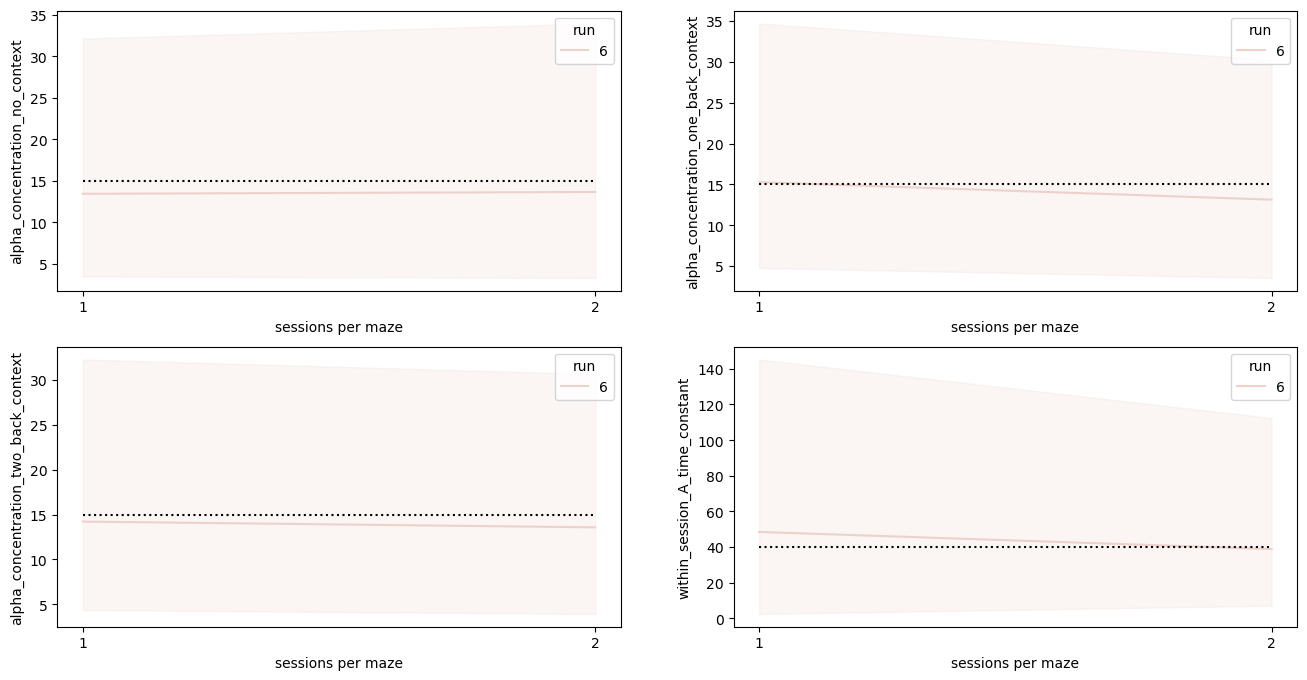

In [49]:
parameters_s = parameters.stack([1,2]).reset_index()    
n_cols = 2
n_rows = int(np.ceil(len(true_parameters)/float(n_cols)))
plt.figure(figsize=(n_cols*8,n_rows*4))

for ii, p_name in enumerate(true_parameters.keys()):
    plt.subplot(n_rows, n_cols, ii+1)
    # for each parameter in the data frame, make a plot of 95% CI and mean over time vs. true params
    pp = sns.lineplot(x="sessions per maze", y=p_name,
                hue="run", errorbar=("pi",95),
                data=parameters_s)
    plt.plot([min_blocks_per_type,max_blocks_per_type], [true_parameters[p_name], true_parameters[p_name]], "k:")
    pp.set_xticks(range(min_blocks_per_type,max_blocks_per_type+1))

In [50]:
xx = samples["transition_probabilities"]["probabilities"].squeeze();
xx.shape

print(samples["transition_probabilities"]["contexts"])
print(model._predictive_transition_probability_setup["groups_numbers_each_level"])
model.num_groups

iis = [np.where(model._groupings_compact[:,-1] == xx)[0][0] for xx in range(model.num_groups[-1])]

print(model._groupings[iis,:])
model._Y

['0-0-', '0-1-', '0-2-', '1-0-', '1-1-', '1-2-', '2-0-', '2-1-', '2-2-']
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 3, 4, 5, 6, 7, 8]]
[['' '0-' '0-0-']
 ['' '1-' '0-1-']
 ['' '2-' '0-2-']
 ['' '0-' '1-0-']
 ['' '1-' '1-1-']
 ['' '2-' '1-2-']
 ['' '0-' '2-0-']
 ['' '1-' '2-1-']
 ['' '2-' '2-2-']
 ['' '0-' 'NULL-0-']
 ['' 'NULL-' 'NULL-NULL-']]


array([0, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2,
       0, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1, 1, 1, 1,
       0, 1, 1, 1, 2, 2, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

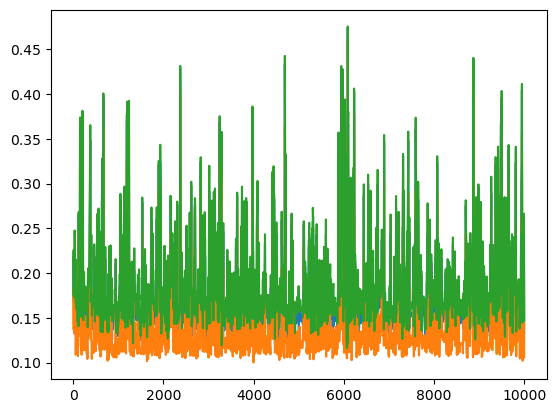

In [54]:
plt.plot(range(0,10000,5),xx[::5,0,1::3].squeeze())
